In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from cycler import cycler

rc("font", family="serif", size=14)
rc("text", usetex=True)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['patch.linewidth'] = 2
matplotlib.rcParams['axes.prop_cycle'] =\
    cycler("color", ['k', 'c', 'm', 'y'])
matplotlib.rcParams['axes.labelsize'] = 16

import numpy as np
from scipy.stats import truncnorm, rayleigh, chi2, norm, gamma

# Road map
In this notebook, I will
- generate some simple (Gaussian and non-Gaussian) 1D fields from a 1D power spectrum,
- compare various estimators of the power spectrum and its covariance,
- show how to draw correlated fields and obtain estimators that have a much smaller variance,
- show how using auxiliary simscan reduce the variance further, also for the covariance matrix.

# Drawing 1D fields from power spectra

We first check that we can draw Gaussian random fields, including with a method that draws the amplitudes and phases separately (as in Angulo and Pontzen), which will be useful later. 

First, define functions to draw a 1D Gaussian random field. The first one is the classic way, which draws both the phases and the amplitudes. The second way keeps the amplitudes fixed and only draw the phases.

In [2]:
def draw_gaussian_field(powespec):
    k = powespec.size
    comp = np.zeros((k, ), dtype=np.complex)
    comp.real[0] = np.sqrt(powespec[0]) * np.random.randn(1)
    comp.real[1:] = np.sqrt(powespec[1:] / 2) * np.random.randn(k-1)
    comp.imag[1:] = np.sqrt(powespec[1:] / 2) * np.random.randn(k-1)
    return comp

def draw_gaussian_field_fixedPS(powespec):
    k = powespec.size
    comp = np.zeros((k, ), dtype=np.complex)
    phases = np.random.uniform(0, 2*np.pi, k)
    comp.real[0] = np.sqrt(powespec[0])
    comp.real[1:] = np.sqrt(powespec[1:]) * np.cos(phases[1:])
    comp.imag[1:] = np.sqrt(powespec[1:]) * np.sin(phases[1:])
    return comp

Let's check that it works: we draw a few fields and check that the mean power spectrum is correct.

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


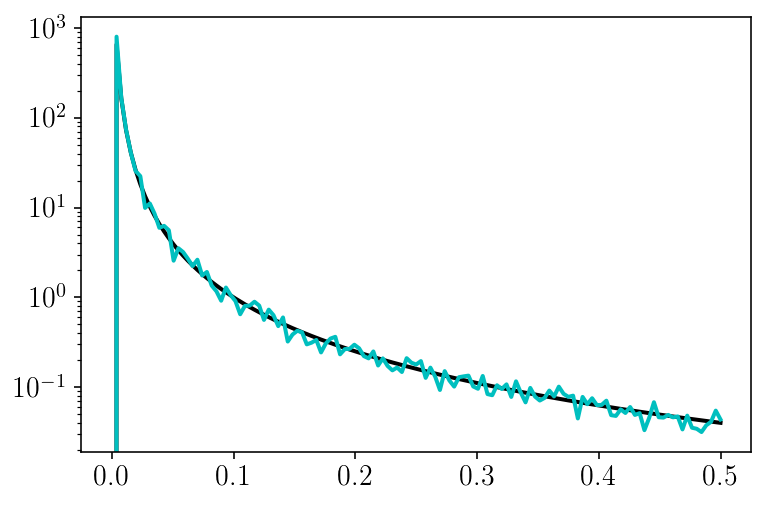

In [3]:
ndim = 256
ks = np.fft.rfftfreq(ndim)
powerspectrum = 0.01*ks**-2.
powerspectrum[ks == 0] = 0
k = ks.size

plt.plot(ks, powerspectrum)

n_repeat = 40
measpowerspectrum = 0*powerspectrum
for i in range(n_repeat):
    y_fft = draw_gaussian_field(powerspectrum)
    measpowerspectrum += np.abs(y_fft)**2 / n_repeat
    
plt.plot(ks, measpowerspectrum)

plt.yscale('log')

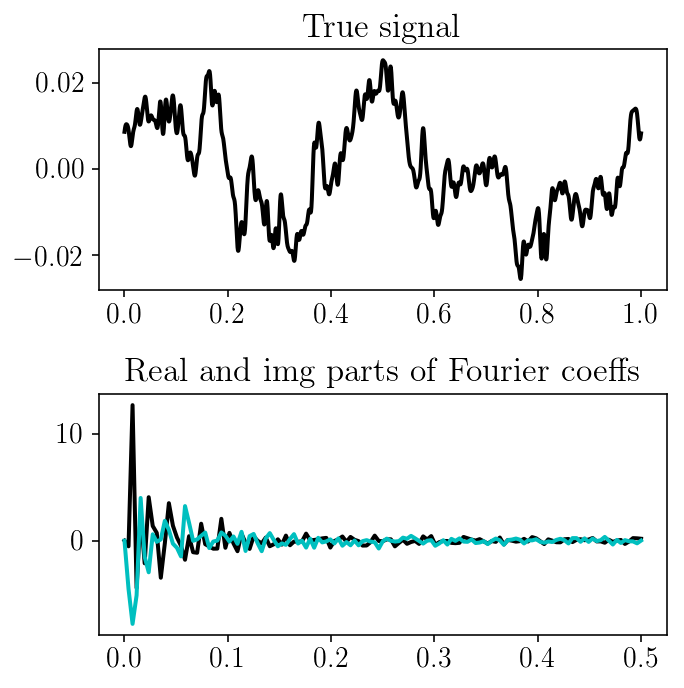

In [4]:
nrec = 10*ndim
x_grid = np.linspace(0, 1, nrec)
y_grid = np.fft.irfft(y_fft, nrec)  # Reconstruct signal, with zero padding.

# Plot the true signals and the noisy data!
fig, axs = plt.subplots(2, 1, figsize=(5, 5))
axs[0].set_title('True signal')
axs[0].plot(x_grid, y_grid)
axs[1].set_title('Real and img parts of Fourier coeffs')
axs[1].plot(ks, y_fft.real)
axs[1].plot(ks, y_fft.imag)
fig.tight_layout()

Let us check out procedure more accurately: let us draw a set of field realizations with multiple mode realizations per fourier mode. This is to mimic the fact that in 2+ dimensions we observe each isotropic mode multiple times.

We want to compare the standard method of drawing Gaussian random fields with the alternative method of first drawing the amplitudes and then drawing the phases afterwards, using the function we wrote above. To draw the amplitudes, we use a truncated normal. This might not be obvious but it is correct.

In [5]:
from scipy.stats import chi2

n_realizations = 100
n_modes = 10

fields1 = np.zeros((n_realizations, nrec))
fields2 = np.zeros((n_realizations, nrec))
powerspectra1 = np.zeros((n_realizations, k))
powerspectra2 = np.zeros((n_realizations, k))
for i in range(n_realizations):
    for j in range(n_modes):
        y_fft_input = draw_gaussian_field(powerspectrum)
        fields1[i, :] =np.fft.irfft(y_fft_input, nrec)
        powerspectra1[i, :] += np.abs(y_fft_input)**2 / n_modes
    powerspectra2[i, 1:] = [truncnorm.rvs(a=-np.sqrt(n_modes), 
                                          b=10, loc=pk, 
                                          scale=pk/np.sqrt(n_modes)) 
                            for pk in powerspectrum[1:]]
    y_fft_input2 = draw_gaussian_field_fixedPS(powerspectra2[i, :])
    fields2[i, :] = np.fft.irfft(y_fft_input2, nrec)

I now plot the mean of the power spectra measured in the two sets of fields. We see that the two methods are nicely unbiased and indeed follow the right power spectrum.

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


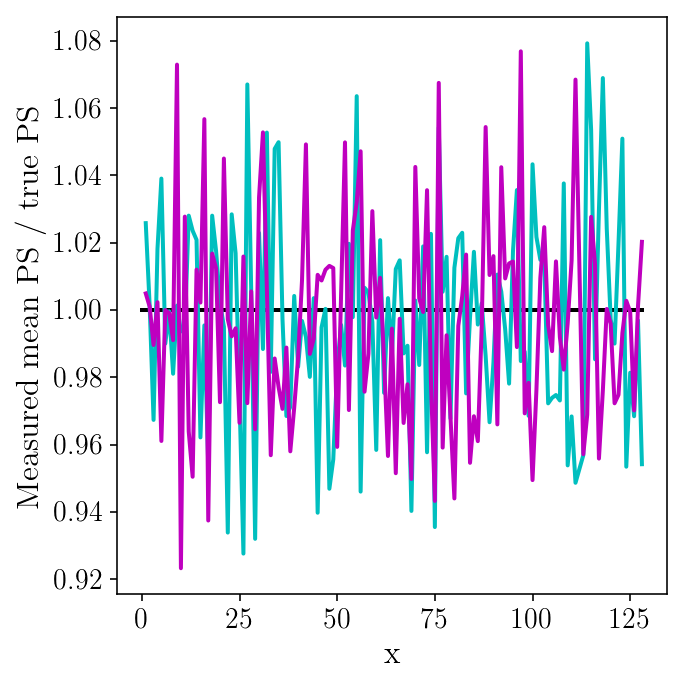

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(powerspectrum*0+1)
ax.plot(powerspectra1.mean(axis=0)/powerspectrum)
ax.plot(powerspectra2.mean(axis=0)/powerspectrum)
ax.set_xlabel('x'); ax.set_ylabel('Measured mean PS / true PS')
fig.tight_layout()

We do the same thing for the variance: we check that the variance corresponds indeed to that of a Gaussian random field and that the two methods for drawing the fields agree.

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


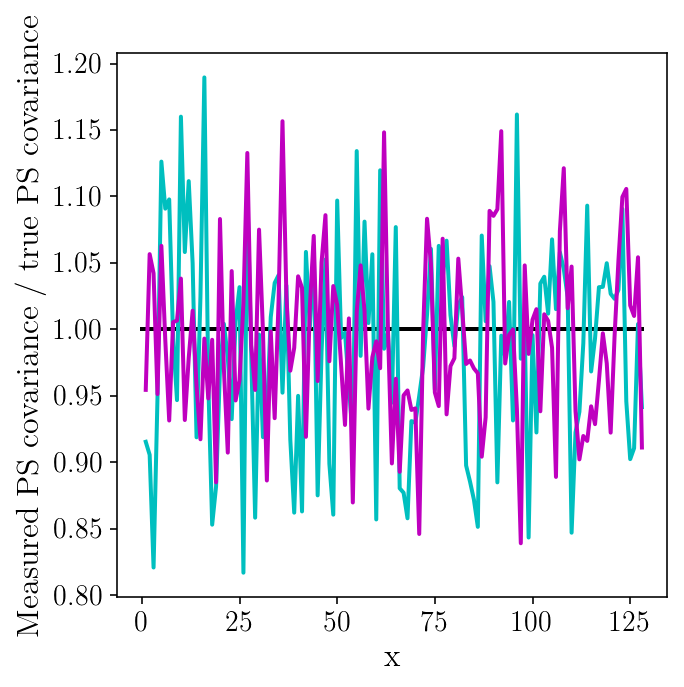

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(powerspectrum*0+1)
ax.plot(powerspectra1.std(axis=0)/powerspectrum*np.sqrt(n_modes))
ax.plot(powerspectra2.std(axis=0)/powerspectrum*np.sqrt(n_modes))
ax.set_xlabel('x'); ax.set_ylabel('Measured PS stddev / true PS stddev')
fig.tight_layout()

Finally, we plot the fields and check that they are Gaussian.

-5.20417042793e-21 0.0180262136262


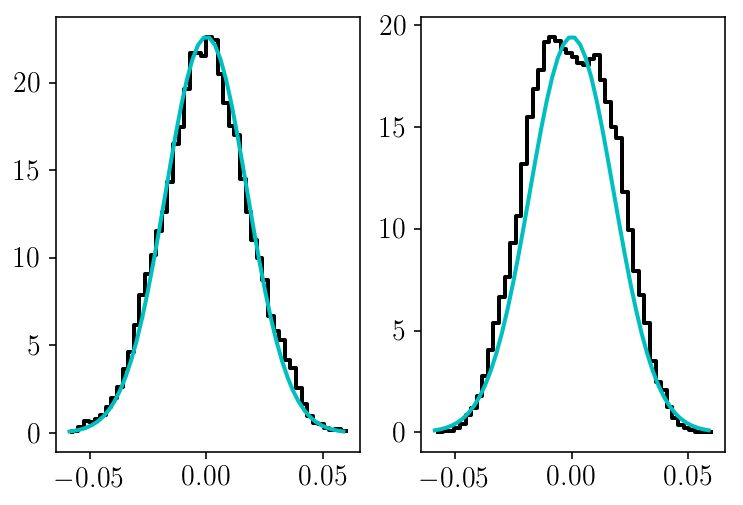

In [8]:
rr = [-0.06, 0.06]#[np.min(fields1), np.max(fields1)]
nbins = 50
fig, axs = plt.subplots(1, 2)
_, bins_e = np.histogram(fields1[0, :], bins=nbins, range=rr, normed=True)
bins_c = (bins_e[1:]+bins_e[:-1])/2
hists1 = np.array([np.histogram(fields1[i, :], bins=nbins, range=rr, normed=True)[0] for i in range(n_realizations)]).reshape((n_realizations, -1))
axs[0].plot(bins_e[1:], hists1.mean(axis=0), ls='steps')
hists2 = np.array([np.histogram(fields2[i, :], bins=nbins, range=rr, normed=True)[0] for i in range(n_realizations)]).reshape((n_realizations, -1))
axs[1].plot(bins_e[1:], hists2.mean(axis=0), ls='steps')
mean = np.mean([np.mean(fields1[i, :]) for i in range(n_realizations)])
sig = np.mean([np.std(fields1[i, :]) for i in range(n_realizations)])
axs[0].plot(bins_c, np.max(hists1.mean(axis=0))*np.exp(-0.5*((bins_c - mean)/sig)**2))
mean = np.mean([np.mean(fields2[i, :]) for i in range(n_realizations)])
sig = np.mean([np.std(fields2[i, :]) for i in range(n_realizations)])
axs[1].plot(bins_c, np.max(hists2.mean(axis=0))*np.exp(-0.5*((bins_c - mean)/sig)**2))
print(mean, sig)

# Drawing correlated Gaussian random fields

We now develop methods to draw correlated Gaussian random fields. In our first attempt, we keep the power spectrum fixed and draw N fields by drawing their phases in a correlated way. 

In [9]:
def draw_correlated_gaussian_field(powespec, N, beta):
    k = powespec.size
    cov = np.diag(np.repeat(1 - beta, N)) + beta
    comp = np.zeros((k, N), dtype=np.complex)
    mu = np.repeat(0, N)
    comp.real[0, :] = np.sqrt(powespec[0]) * np.random.multivariate_normal(mu, cov, 1)
    comp.real[1:, :] = np.sqrt(powespec[1:] / 2)[:, None] * np.random.multivariate_normal(mu, cov, k-1)
    comp.imag[1:, :] = np.sqrt(powespec[1:] / 2)[:, None] * np.random.multivariate_normal(mu, cov, k-1)
    return comp.T

Ncorr = 3
beta = 0.5 * -1 / (Ncorr - 1)
test = draw_correlated_gaussian_field(powerspectrum, Ncorr, beta)

We are now going to check that the variance of the mean power spectrum obtained from the correlated fields is smaller than that obtained with the uncorrelated fields.

In [10]:
n_repeat = 10
n_realizations = 100
Ncorr = 2
if Ncorr == 1:
    beta = 0
else:
    beta = 0.9 * -1 / (Ncorr - 1)

def correlated_packets(n_repeat, n_realizations, Ncorr, beta):
    y_fft_withbeta = np.zeros((n_repeat, n_realizations, Ncorr, k), dtype=complex)
    for j in range(n_repeat):
        for i in range(n_realizations):
            y_fft_input = draw_correlated_gaussian_field(powerspectrum, Ncorr, beta)
            fields = np.fft.irfft(y_fft_input, nrec)
            y_fft_withbeta[j, i, :, :] = np.fft.rfft(fields)[:, :k]
    return y_fft_withbeta

y_fft_nobeta = correlated_packets(n_repeat, n_realizations, Ncorr, 0)
y_fft_withbeta = correlated_packets(n_repeat, n_realizations, Ncorr, beta)
meanfield_nobeta = np.mean(y_fft_nobeta, axis=(1, 2))
meanfield_withbeta = np.mean(y_fft_withbeta, axis=(1, 2))

We verify that the mean field is zero.

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/bl/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


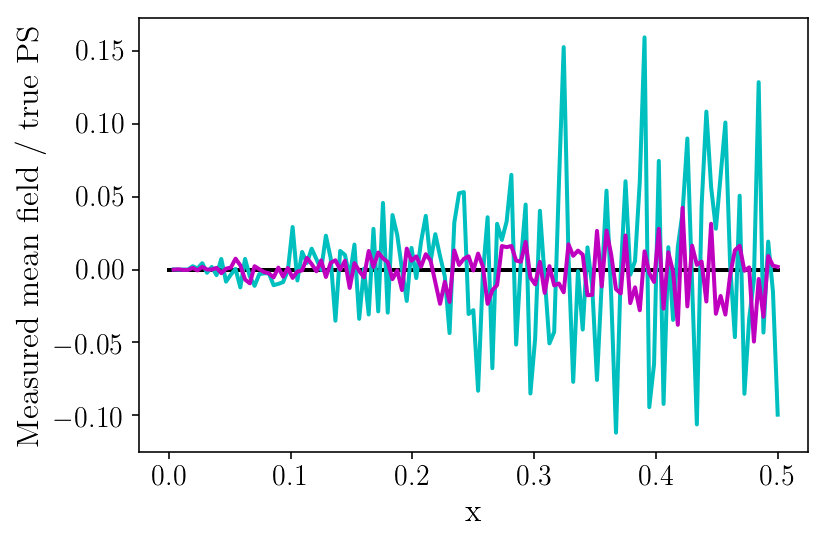

In [11]:
plt.plot(ks, 0*powerspectrum)
plt.plot(ks, meanfield_nobeta.mean(axis=0)/powerspectrum)
plt.plot(ks, meanfield_withbeta.mean(axis=0)/powerspectrum)
plt.xlabel('x'); plt.ylabel('Measured mean field / true PS')

And that the variance of the field is smaller for the correlated set... But as we can see, this means our power spectrum measurement is biased! This is expected because we have drawn (correlated) random phases while fixing the power spectrum. We need another methods.

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


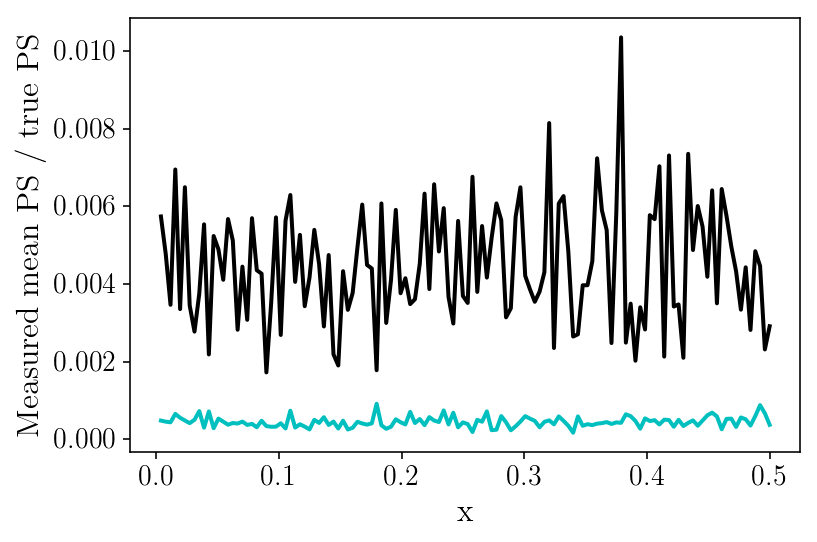

In [12]:
plt.plot(ks, meanfield_nobeta.var(axis=0)/powerspectrum)
plt.plot(ks, meanfield_withbeta.var(axis=0)/powerspectrum)
plt.xlabel('x'); plt.ylabel('Measured mean PS / true PS')

## Digression

What is the distribution of the amplitudes of a complex Gaussian random field? It's a chi-square  with two degrees of freedom! (This is equivalent to a Gamma distribution). And It's not well approximated by a truncated Gaussian or anything.

Why is this a problem? Because we need to draw correlated random power spectra!

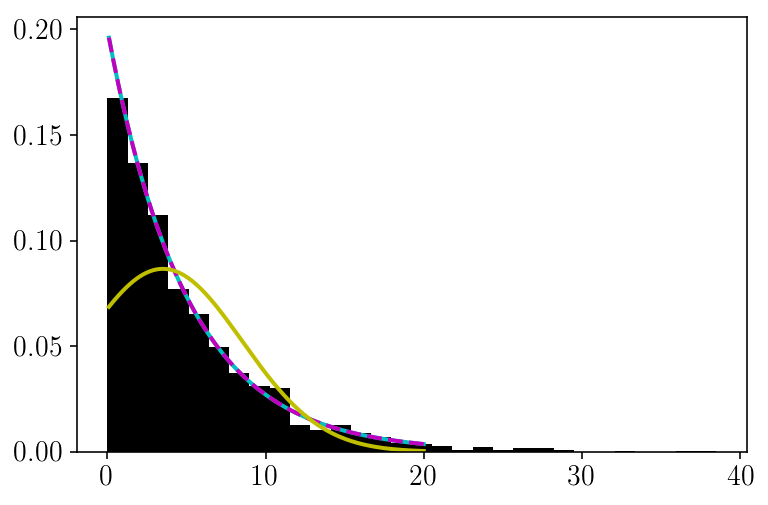

In [13]:
var = 5
num = 2000
bins = np.linspace(0.1, var*4, 200)

rep = 2
xs = (var/2)**0.5 * (np.random.randn(num, rep//2) + 1j*np.random.randn(num, rep//2))
plt.hist(np.mean(np.absolute(xs)**2., axis=1), 30, normed=True)
plt.plot(bins, chi2.pdf(bins, df=rep, scale=var/rep))
plt.plot(bins, gamma.pdf(bins, a=rep/2, scale=var), ls='dashed')

median = var * (1 - 2./9./rep)**3
mu = var/rep*rep
plt.plot(bins, truncnorm.pdf(bins, a=-np.sqrt(rep), b=bins[-1], loc=median, scale=var*np.sqrt(2/rep)))
xs2 = truncnorm.rvs(size=10000, a=-np.sqrt(rep), b=bins[-1], loc=median, scale=var*np.sqrt(2/rep))

## Copula method for drawing valid correlated power spectra

How could we draw the amplitudes of our random fields (the measured power spectra) such that each of them is drawn from this gamma distribution, but they are also correlated? In other words, how do we draw correlated gamma random variables?

We use the method of copula: we draw (anti-)correlated Gaussian random variables and use the cumulative distributions of the Gaussian and the Gamma to remap and transform the Gaussian random variables into Gamma ones.

The only disadvantage of this method is that the correlation of the Gamma variables will be lower than that of the initial random Gaussian variables. At this stage we will be happy with that. We will see that those Gamma variables retain quite a lot of correlation. But it would be great to improve this generation process and manage to draw Gamma variables with more correlation!

The plots below show that it works.

-0.906571748632 -0.900860752244 -0.625291571986


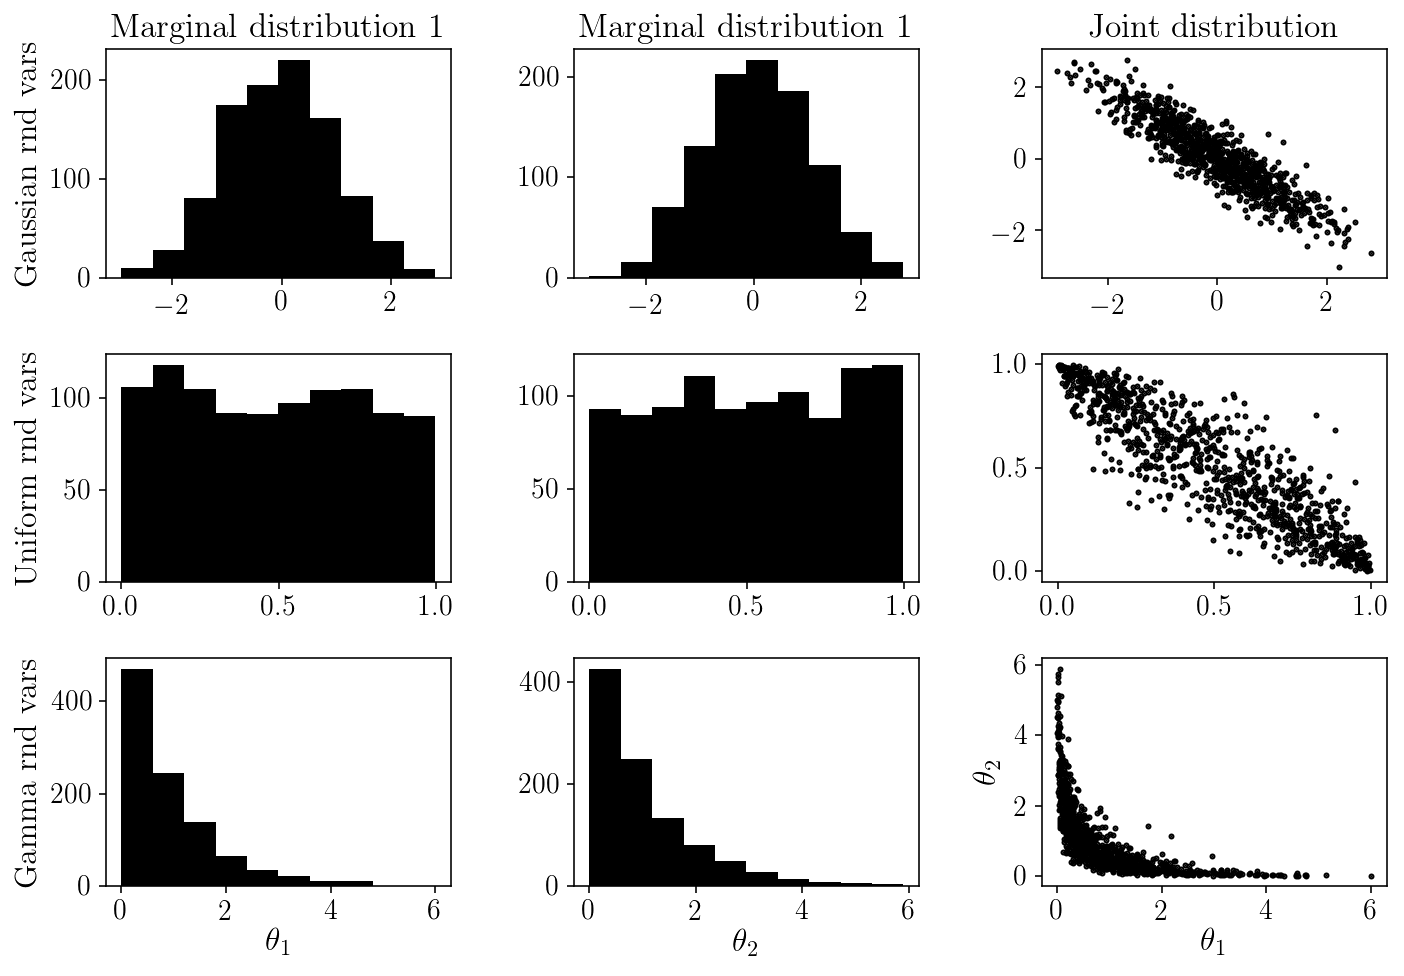

In [14]:
N = 2
gam = 0.9 * -1/(N-1)
num = 1000
shape = 1
cov = np.diag(np.repeat(1 - gam, N)) + gam
mu = np.repeat(0, N)
xs = np.random.multivariate_normal(mu, cov, size=num)
ys = norm.cdf(xs)
zs = gamma.ppf(ys, a=shape)


fig, axs = plt.subplots(3, 3, figsize=(10, 7))
axs[0, 0].set_ylabel('Gaussian rnd vars')
axs[1, 0].set_ylabel('Uniform rnd vars')
axs[2, 0].set_ylabel('Gamma rnd vars')
axs[0, 0].set_title('Marginal distribution 1')
axs[0, 1].set_title('Marginal distribution 1')
axs[0, 2].set_title('Joint distribution')
axs[2, 0].set_xlabel(r'$\theta_1$')
axs[2, 1].set_xlabel(r'$\theta_2$')
axs[2, 2].set_xlabel(r'$\theta_1$')
axs[2, 2].set_ylabel(r'$\theta_2$')
axs[0, 0].hist(xs[:, 0])
axs[0, 1].hist(xs[:, 1])
axs[0, 2].scatter(xs[:, 0], xs[:, 1], s=1)
axs[1, 0].hist(ys[:, 0])
axs[1, 1].hist(ys[:, 1])
axs[1, 2].scatter(ys[:, 0], ys[:, 1], s=1)
axs[2, 0].hist(zs[:, 0])
axs[2, 1].hist(zs[:, 1])
axs[2, 2].scatter(zs[:, 0], zs[:, 1], s=1)
fig.tight_layout()
print(np.corrcoef(xs.T)[1, 0], np.corrcoef(ys.T)[1, 0], np.corrcoef(zs.T)[1, 0])

## Back to generating correlated random fields!

We now know how to generate correlated random power spectra for our random fields.

Let us also define two function to 'perturb' and transform each field, in Fourier and real space. This is to emulate the fact that N-body simulations are 'processed', evolved versions of a Gaussian random field. We are interested in estimating power spectra and covariances of those evolved fields.

For this reason we will focus on that.

Let us generate, transform, and plot one field:

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/Users/bl/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide


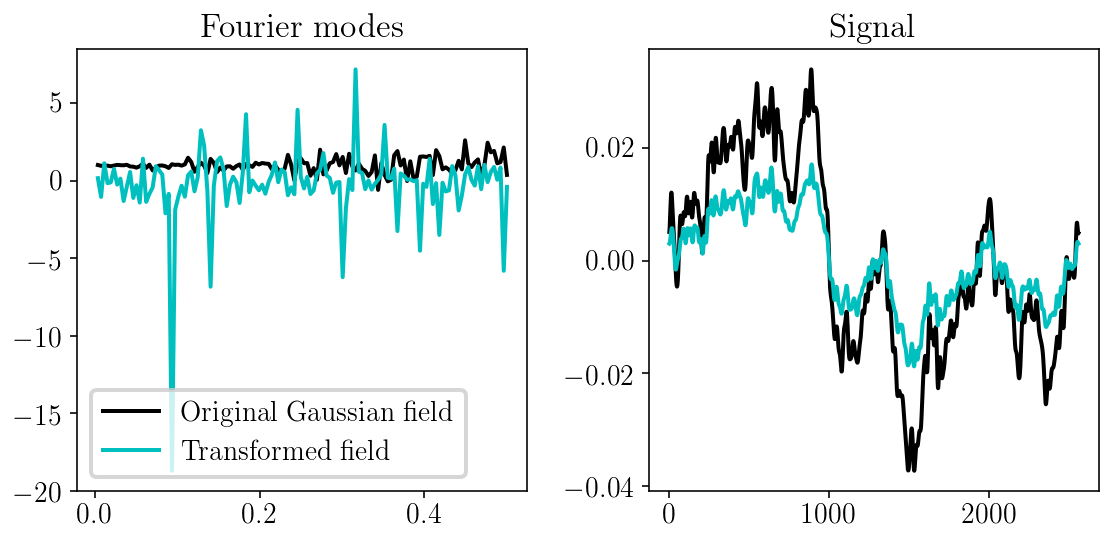

In [15]:
def transform_realspace(arr):
    return  arr**1/2 #* (1 + np.random.randn(arr.size))

def transform_fourierspace(arr):
    k = arr.size
    return arr * (1 + np.random.randn(arr.size) * np.arange(1, k+1)/k )

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
y_fft1 = draw_gaussian_field(powerspectrum)
y_fft2 = transform_fourierspace(y_fft1)
y_grid1 = np.fft.irfft(y_fft1, nrec)
y_grid2 = transform_realspace(np.fft.irfft(y_fft2, nrec))
y_fft3 = np.fft.rfft(y_grid)[:k]
axs[0].plot(ks, y_fft2/y_fft1, label='Original Gaussian field'); 
axs[0].plot(ks, y_fft3/y_fft1, label='Transformed field');
axs[0].legend()
axs[1].plot(y_grid1); axs[1].plot(y_grid2);
axs[0].set_title('Fourier modes')
axs[1].set_title('Signal')
fig.tight_layout()

Let us now generate a bunch of simulated fields, without and with this transformation.

We will compare three sets of draws: 1) the standard Gaussian Random Field (GRF) draws (both phases and amplitudes drawn), 2) the uncorrelated Gamma draws, and 3) the correlated Gamma draws.

1 and 2 should agree pretty well. For 3 we will try to impose maximally anti-correlation. As shown in my notes for a Gaussian random field we must have > -1/(Ncorr-1). Also, the transformation from Gaussian to Gamma variables reduces the anti-correlation a little bit, as we will show below.

In [16]:
n_realizations_ref = 2000  # * Ncorr * n_modes
n_realizations = 100
 
n_repeat = 10
n_modes = 10
Ncorr = 2
beta_in = 0.9999 * -1 / (Ncorr - 1)
    
def generate_correlated_gamma(num, N, powerspectrum, beta, shape=8):
    zs = np.zeros((num, N, powerspectrum.size))
    for ik, pk in enumerate(powerspectrum):
        if ik > 0:
            cov = np.diag(np.repeat(1 - beta, N)) + beta
            mu = np.repeat(0, N)
            xs = np.random.multivariate_normal(mu, cov, size=num)
            ys = norm.cdf(xs)
            zs[:, :, ik] = gamma.ppf(ys, a=shape, scale=pk/8)
    return zs

powerspectrum_ref = np.zeros((n_realizations_ref, Ncorr, k))
powerspectra_nobeta1 = np.zeros((n_repeat, n_realizations, Ncorr, k))
powerspectra_nobeta2 = np.zeros((n_repeat, n_realizations, Ncorr, k))
powerspectra_withbeta = np.zeros((n_repeat, n_realizations, Ncorr, k))

powerspectra_i_nobeta1 = np.zeros((n_repeat, n_realizations, Ncorr, k))
powerspectra_i_nobeta2 = np.zeros((n_repeat, n_realizations, Ncorr, k))
powerspectra_i_withbeta = np.zeros((n_repeat, n_realizations, Ncorr, k))
for n in range(n_repeat):
    powerspectra_i_nobeta2[n, :, :, :] = generate_correlated_gamma(n_realizations, Ncorr, powerspectrum, 0)
    powerspectra_i_withbeta[n, :, :, :] = generate_correlated_gamma(n_realizations, Ncorr, powerspectrum, beta_in)

beta = np.mean([np.sum(np.corrcoef(powerspectra_i_withbeta[:, :, :, ik].reshape((-1, Ncorr)).T)-np.eye(Ncorr))/(Ncorr**2-Ncorr) 
                for ik in range(1, k)])

for i in range(n_realizations_ref):
    for j in range(Ncorr):
        for m in range(n_modes):
            y_fft_input = draw_gaussian_field(powerspectrum)
            y_fft_transformed = np.fft.rfft(transform_realspace(np.fft.irfft(transform_fourierspace(y_fft_input), nrec)))[:k]
            powerspectrum_ref[i, j, :] += np.abs(y_fft_transformed)**2 / n_modes
    
for n in range(n_repeat):

    for i in range(n_realizations):
    
        for j in range(Ncorr):

            for m in range(n_modes):
                y_fft_input = draw_gaussian_field(powerspectrum)
                y_fft_transformed = np.fft.rfft(transform_realspace(np.fft.irfft(transform_fourierspace(y_fft_input), nrec)))[:k]
                powerspectra_i_nobeta1[n, i, j, :] += np.abs(y_fft_input)**2 / n_modes
                powerspectra_nobeta1[n, i, j, :] += np.abs(y_fft_transformed)**2 / n_modes

                y_fft_input2 = draw_gaussian_field_fixedPS(powerspectra_i_nobeta2[n, i, j, :])
                y_fft_transformed2 = np.fft.rfft(transform_realspace(np.fft.irfft(transform_fourierspace(y_fft_input2), nrec)))[:k]
                powerspectra_nobeta2[n, i, j, :] += np.abs(y_fft_transformed2)**2 / n_modes

                y_fft_input2 = draw_gaussian_field_fixedPS(powerspectra_i_withbeta[n, i, j, :])
                y_fft_transformed2 = np.fft.rfft(transform_realspace(np.fft.irfft(transform_fourierspace(y_fft_input2), nrec)))[:k]
                powerspectra_withbeta[n, i, j, :] += np.abs(y_fft_transformed2)**2 / n_modes

Let us quickly look at the ratio of the power spectra between the initial Gaussian random field and the evolved one.

In [17]:
powerspectrum_ref_mean = powerspectrum_ref.mean(axis=(0, 1))
powerspectrum_ref_var = powerspectrum_ref.var(axis=(0, 1))

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


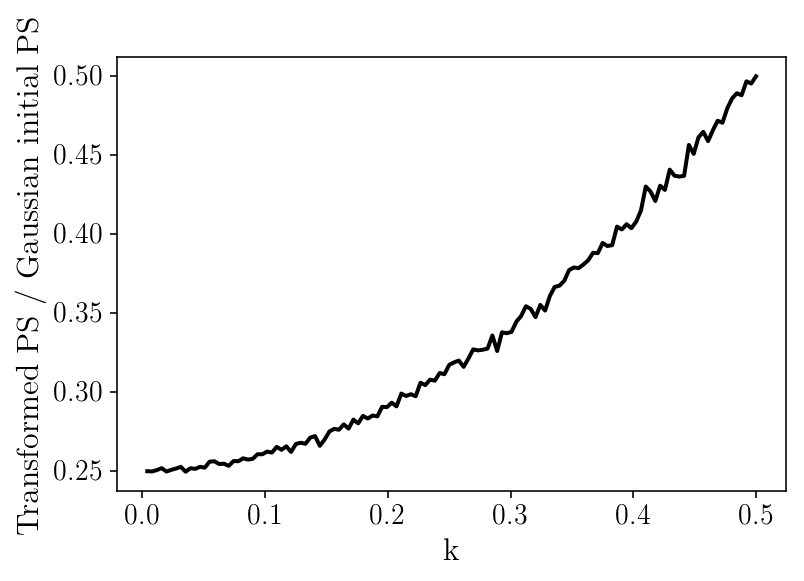

In [18]:
plt.plot(ks, powerspectrum_ref_mean/powerspectrum)
plt.ylabel('Transformed PS / Gaussian initial PS')
plt.xlabel('k')

We now compure the mean estimated power spectra from the initial Gaussian random field simulations (we will look at the transformed ones below). We immediately see that the correlated draws indeed lead to a smaller variance!

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


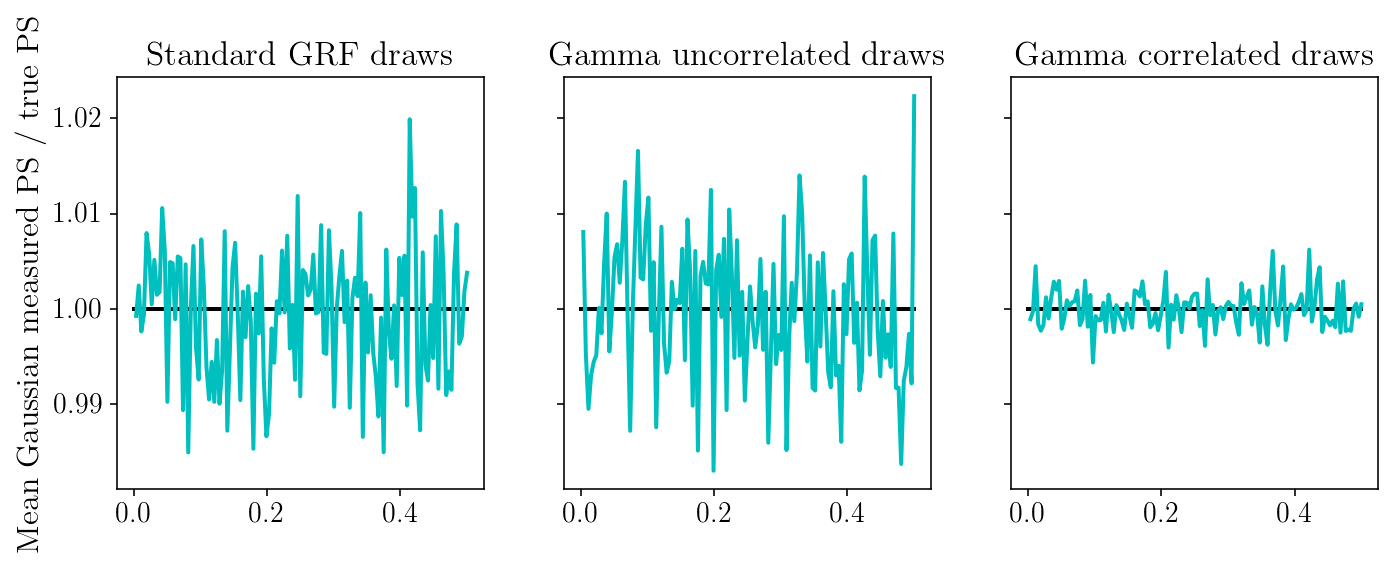

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
axs[0].plot(ks, powerspectrum*0+1)
axs[1].plot(ks, powerspectrum*0+1)
axs[2].plot(ks, powerspectrum*0+1)
axs[0].plot(ks, powerspectra_i_nobeta1.mean(axis=(0, 1, 2))/powerspectrum)
axs[1].plot(ks, powerspectra_i_nobeta2.mean(axis=(0, 1, 2))/powerspectrum)
axs[2].plot(ks, powerspectra_i_withbeta.mean(axis=(0, 1, 2))/powerspectrum)
axs[0].set_ylabel('Mean Gaussian measured PS / true PS')
axs[0].set_title('Standard GRF draws')
axs[1].set_title('Gamma uncorrelated draws')
axs[2].set_title('Gamma correlated draws')
fig.tight_layout()

We can prove that this variance agree pretty well with the theoretical prediction derived in the notes.

0.00487906062504 0.005 0.975812125009
0.00516916067953 0.005 1.03383213591
0.000298926313496 0.000270414156562 1.1054388472


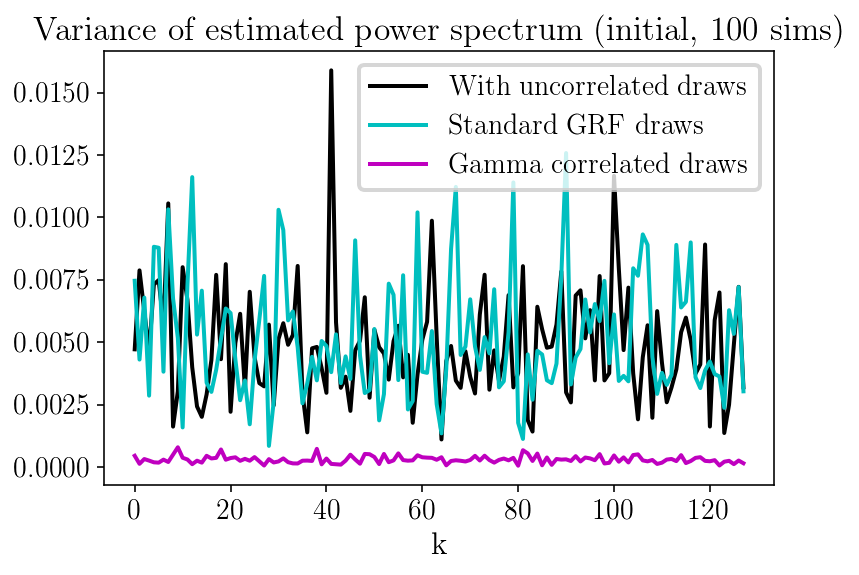

In [20]:
truevar = 1 * powerspectrum[1:]**2.0 / n_modes
meas = np.var(powerspectra_i_nobeta1.mean(axis=(1, 2)), axis=0)[1:] / truevar
plt.plot(meas, label='With uncorrelated draws')
mod = 1 / n_realizations / Ncorr
print(meas.mean(), mod, meas.mean()/mod)
meas = np.var(powerspectra_i_nobeta2.mean(axis=(1, 2)), axis=0)[1:] / truevar
plt.plot(meas, label='Standard GRF draws')
mod = 1 / n_realizations / Ncorr
print(meas.mean(), mod, meas.mean()/mod)
meas = np.var(powerspectra_i_withbeta.mean(axis=(1, 2)), axis=0)[1:] / truevar
plt.plot(meas, label='Gamma correlated draws')
mod = (1 + (Ncorr-1)*beta) / n_realizations / Ncorr
print(meas.mean(), mod, meas.mean()/mod)
plt.legend()
plt.xlabel('k')
plt.title('Variance of estimated power spectrum (initial, '+str(n_realizations)+' sims)')

We now perform the same test but on the transformed field. I have estimated the true power spectrum with many more simulations. We again see that the simulations give the correct mean power spectrum, and that the anti-correlated draws lead to a smaller variance.

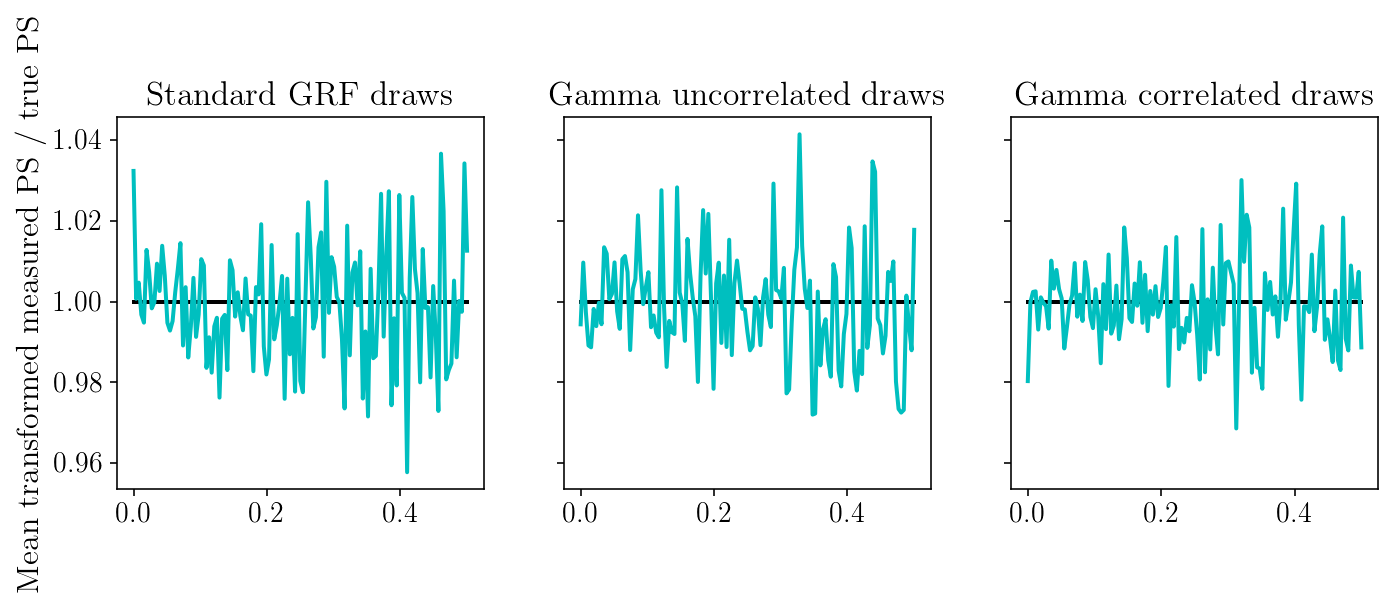

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
axs[0].plot(ks, powerspectrum*0+1)
axs[1].plot(ks, powerspectrum*0+1)
axs[2].plot(ks, powerspectrum*0+1)
axs[0].plot(ks, powerspectra_nobeta1.mean(axis=(0, 1, 2))/powerspectrum_ref_mean)
axs[1].plot(ks, powerspectra_nobeta2.mean(axis=(0, 1, 2))/powerspectrum_ref_mean)
axs[2].plot(ks, powerspectra_withbeta.mean(axis=(0, 1, 2))/powerspectrum_ref_mean)
axs[0].set_ylabel('Mean transformed measured PS / true PS')
axs[0].set_title('Standard GRF draws')
axs[1].set_title('Gamma uncorrelated draws')
axs[2].set_title('Gamma correlated draws')
axs[0].set_xlabel('k')
axs[1].set_xlabel('k')
axs[2].set_xlabel('k')
fig.tight_layout()

0.00477680684953 0.005 0.955361369906
0.00374276386757 0.005 0.748552773513
0.00145505326978 0.000270414156562 5.3808324545


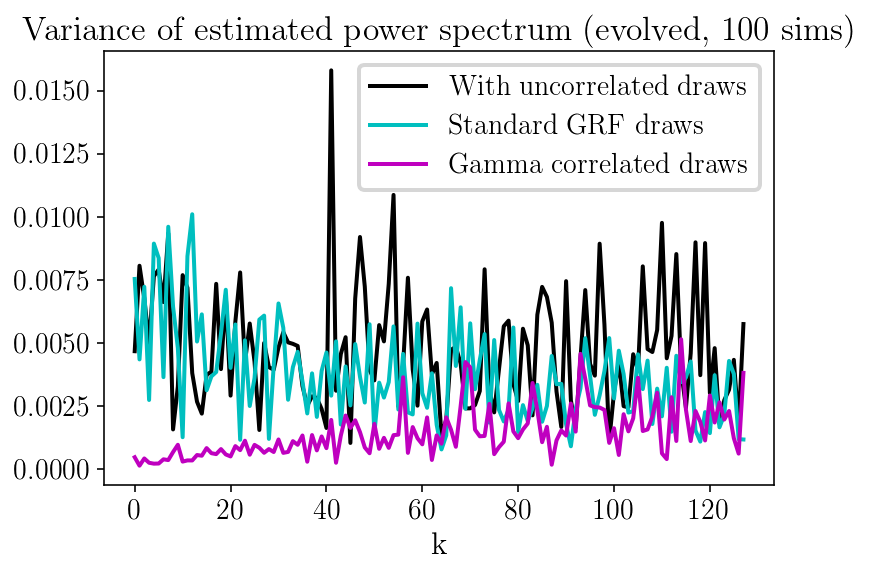

In [22]:
truevar = powerspectrum_ref_var[1:]
meas = np.var(powerspectra_nobeta1.mean(axis=(1, 2)), axis=0)[1:] / truevar
plt.plot(ks, meas, label='With uncorrelated draws')
mod = 1 / n_realizations / Ncorr
print(meas.mean(), mod, meas.mean()/mod)
meas = np.var(powerspectra_nobeta2.mean(axis=(1, 2)), axis=0)[1:] / truevar
plt.plot(ks, meas, label='Standard GRF draws')
mod = 1 / n_realizations / Ncorr
print(meas.mean(), mod, meas.mean()/mod)
meas = np.var(powerspectra_withbeta.mean(axis=(1, 2)), axis=0)[1:] / truevar
plt.plot(ks, meas, label='Gamma correlated draws')
mod = (1 + (Ncorr-1)*beta) / n_realizations / Ncorr
print(meas.mean(), mod, meas.mean()/mod)
plt.legend()
plt.xlabel('k')
plt.title('Variance of estimated power spectrum (evolved, '+str(n_realizations)+' sims)')

Let's look at the correlation coefficient of the power spectra of the initial and the transformed simulations. We generated the initial one at the minium lower bound. But because of our procedure to generated correlated gamma distributions, there is a lot of correlation. For sets of pairs of anti-correlated simulations that we have drawn with beta = -1 we only reach about -0.95 after the copula trick. 

On top of that, our transform fields also suffer from a loss of correlation due to the transformation itself.

-0.945917168688 -0.949035753633 -0.621445779085


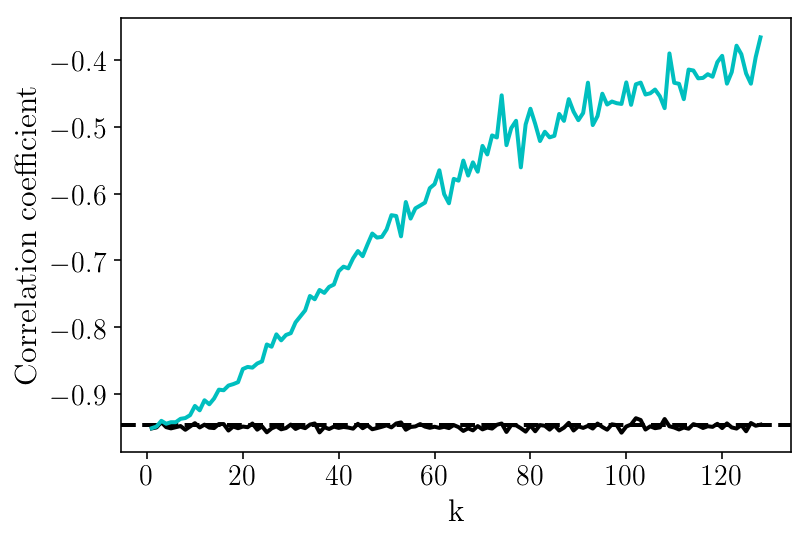

In [23]:
allbeta_obs_input = np.mean([[np.sum(np.corrcoef(powerspectra_i_withbeta[j, :, :, i].T) - np.eye(Ncorr))/(Ncorr**2-Ncorr) 
                      for i in range(1, k)] for j in range(n_repeat)], axis=0)

allbeta_obs = np.mean([[np.sum(np.corrcoef(powerspectra_withbeta[j, :, :, i].T) - np.eye(Ncorr))/(Ncorr**2-Ncorr) 
                        for i in range(1, k)] for j in range(n_repeat)], axis=0)
beta_obs = np.mean(allbeta_obs)
#print(beta_obs, np.std(allbeta_obs), np.min(allbeta_obs), np.max(allbeta_obs), beta)
fig, ax = plt.subplots(1, 1)
ax.axhline(beta, ls='dashed')
ax.plot(range(1, k), allbeta_obs_input)
ax.plot(range(1, k), allbeta_obs)
ax.set_ylabel('Correlation coefficient')
ax.set_xlabel('k')
print(beta, np.mean(allbeta_obs_input), np.mean(allbeta_obs))

# Control variates and auxiliary simulations

Let us know generate another set of simulations, with a different power spectrum, which we will assume to be known and available, unlike that of our primary similations.

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


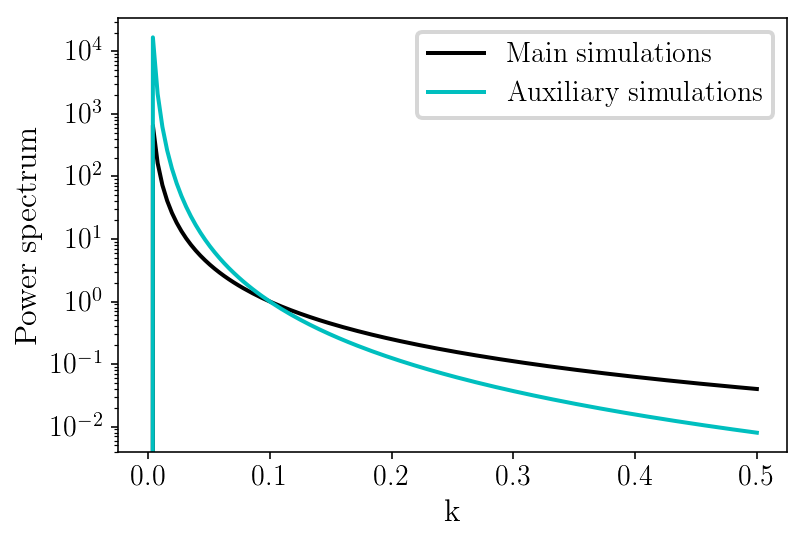

In [432]:
powerspectrum_aux = 0.001*ks**-3.
powerspectrum_aux[ks == 0] = 0

plt.plot(ks, powerspectrum, label='Main simulations')
plt.plot(ks, powerspectrum_aux, label='Auxiliary simulations')
plt.legend()
plt.ylabel('Power spectrum')
plt.xlabel('k')
plt.yscale('log')

Let's generate a set of primary and auxiliary simulations such that they are correlated by pairs. We will use the previous copula method, so we won't quite achieve perfect correlations. What helps us here is that we don't specifically want anti-correlations. And because we know anti-correlations are harder to achieve with the copula method, we will focus on positive (100%) correlations.

In [434]:
n_realizations_ref = 1000
n_realizations = 100
n_repeat = 100
n_modes = 1
beta_in = 1.0
    
def transform_realspace(arr):
    return  arr**1/2

def transform_fourierspace(arr):
    k = arr.size
    return arr * ( 1 + np.arange(1, k+1) / k )

def generate_two_correlated_gamma(num, powerspectrum1, powerspectrum2, beta, shape=1):
    zs = np.zeros((num, 2, powerspectrum1.size))
    for ik, (pk1, pk2) in enumerate(zip(powerspectrum1, powerspectrum2)):
        if ik > 0:
            cov = np.diag(np.repeat(1 - beta, N)) + beta
            mu = np.repeat(0, N)
            xs = np.random.multivariate_normal(mu, cov, size=num)
            ys = norm.cdf(xs)
            zs[:, 0, ik] = gamma.ppf(ys[:, 0], a=shape, scale=pk1/shape)
            zs[:, 1, ik] = gamma.ppf(ys[:, 1], a=shape, scale=pk2/shape)
    return zs

powerspectrum_ref = np.zeros((n_realizations_ref, 2, k))
powerspectra_withbeta = np.zeros((n_repeat, n_realizations, 2, k))
powerspectra_i_withbeta = np.zeros((n_repeat, n_realizations, 2, k))
for n in range(n_repeat):
    powerspectra_i_withbeta[n, :, :, :] = generate_two_correlated_gamma(n_realizations, powerspectrum, powerspectrum_aux, beta_in)

for i in range(n_realizations_ref):
    for j in range(2):
        for m in range(n_modes):
            if j == 0:
                y_fft_input = draw_gaussian_field(powerspectrum)
            if j == 1:
                y_fft_input = draw_gaussian_field(powerspectrum_aux)
            y_fft_transformed = np.fft.rfft(transform_realspace(np.fft.irfft(transform_fourierspace(y_fft_input), nrec)))[:k]
            powerspectrum_ref[i, j, :] += np.abs(y_fft_transformed)**2 / n_modes
    
for n in range(n_repeat):
    for i in range(n_realizations):
        for j in range(2):
            for m in range(n_modes):
                y_fft_input2 = draw_gaussian_field_fixedPS(powerspectra_i_withbeta[n, i, j, :])
                y_fft_transformed2 = np.fft.rfft(transform_realspace(np.fft.irfft(transform_fourierspace(y_fft_input2), nrec)))[:k]
                powerspectra_withbeta[n, i, j, :] += np.abs(y_fft_transformed2)**2 / n_modes

In [435]:
powerspectrum_ref_mean = powerspectrum_ref.mean(axis=(0))
powerspectrum_ref_var = powerspectrum_ref.var(axis=(0))

Let's check that our simulations have the right mean and variance again.

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


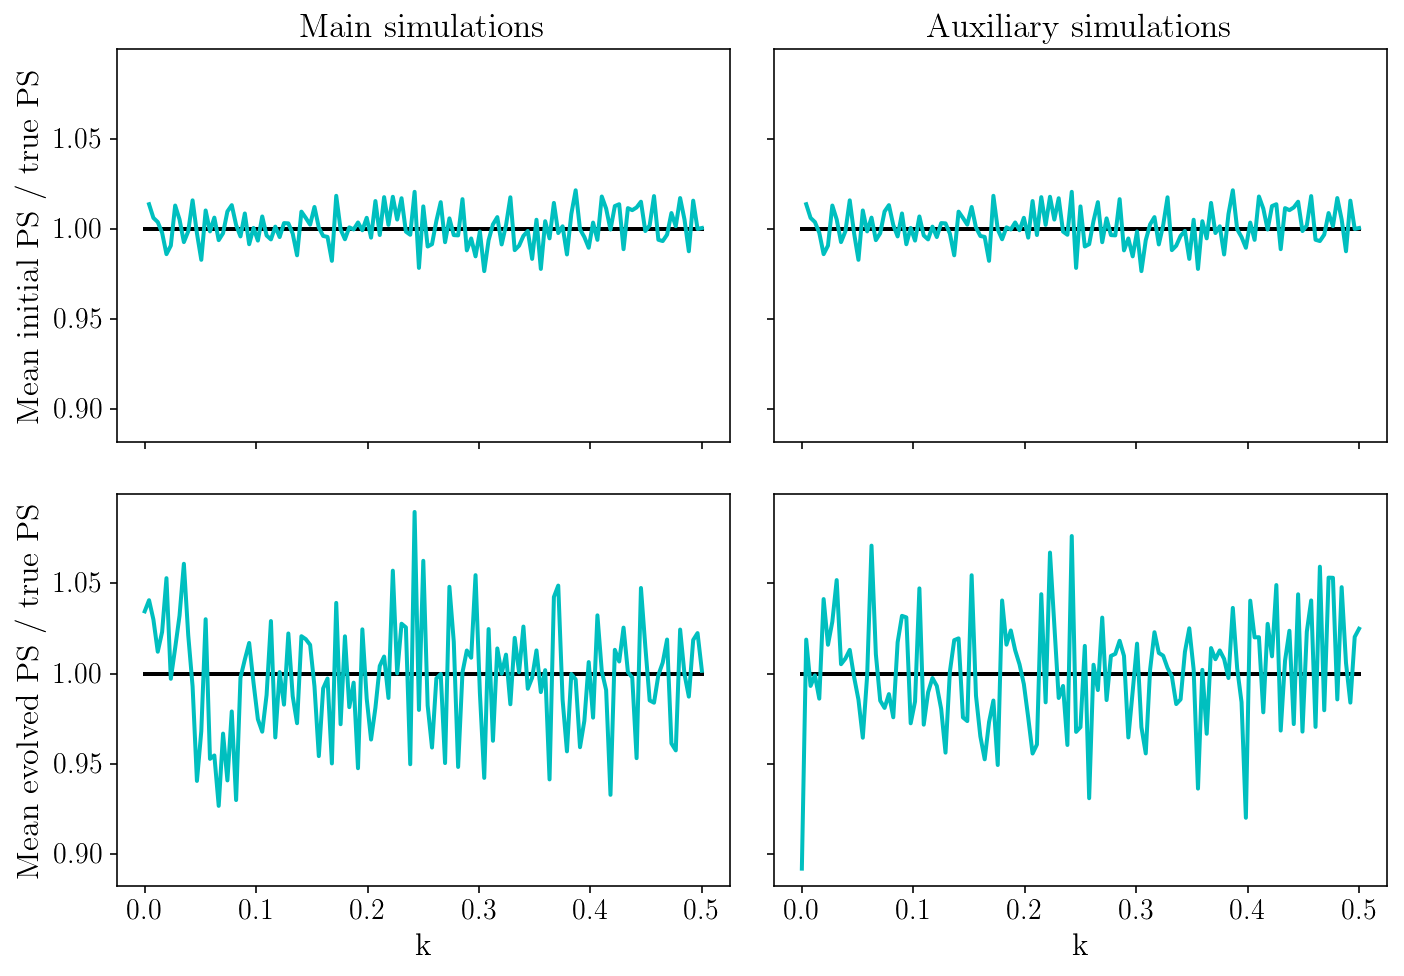

In [436]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)
axs[0, 0].plot(ks, powerspectrum*0+1)
axs[0, 1].plot(ks, powerspectrum*0+1)
axs[0, 0].plot(ks, powerspectra_i_withbeta[:, :, 0, :].mean(axis=(0, 1))/powerspectrum)
axs[0, 1].plot(ks, powerspectra_i_withbeta[:, :, 1, :].mean(axis=(0, 1))/powerspectrum_aux)
axs[1, 0].plot(ks, powerspectrum*0+1)
axs[1, 1].plot(ks, powerspectrum*0+1)
axs[1, 0].plot(ks, powerspectra_withbeta[:, :, 0, :].mean(axis=(0, 1))/powerspectrum_ref_mean[0, :])
axs[1, 1].plot(ks, powerspectra_withbeta[:, :, 1, :].mean(axis=(0, 1))/powerspectrum_ref_mean[1, :])
axs[0, 0].set_title('Main simulations')
axs[0, 0].set_ylabel('Mean initial PS / true PS')
axs[1, 0].set_ylabel('Mean evolved PS / true PS')
axs[0, 1].set_title('Auxiliary simulations')
axs[1, 0].set_xlabel('k')
axs[1, 1].set_xlabel('k')
fig.tight_layout()

Let's construct estimators using both the main and auxiliary simulations, as well as the true value for the latter, and a set of weights alpha. Those "Control Variate" (CV) estimators for the mean and covariance of the initial and transformed fields will have better properties than the standard estimators.

In [437]:
alphas = -6*ks
#alphas = alphas2
differences_i = powerspectra_i_withbeta[:, :, 0, :] +\
    alphas * (powerspectra_i_withbeta[:, :, 1, :] - powerspectrum_aux[None, :])
differences = powerspectra_withbeta[:, :, 0, :] +\
    alphas * (powerspectra_withbeta[:, :, 1, :] - powerspectrum_ref_mean[None, 1, :])

We need to measure the cross-correlation between the two fields too.

In [438]:
cross_powerspectrum_i = np.array([np.cov(powerspectra_i_withbeta[:, :, :, i].reshape(-1, 2).T)[1, 0] 
                         for i in range(ks.size)])
cross_powerspectrum = np.array([np.cov(powerspectra_withbeta[:, :, :, i].reshape(-1, 2).T)[1, 0] 
                         for i in range(ks.size)])
cross_powerspectrum_diff = np.array([np.var(differences[:, :, i], axis=(0, 1)) 
                         for i in range(ks.size)])
cross_powerspectrum_i_diff = np.array([np.var(differences_i[:, :, i], axis=(0, 1)) 
                         for i in range(ks.size)])

Let's check that the sample mean estimator using the differences is unbiased (regardless of alpha)

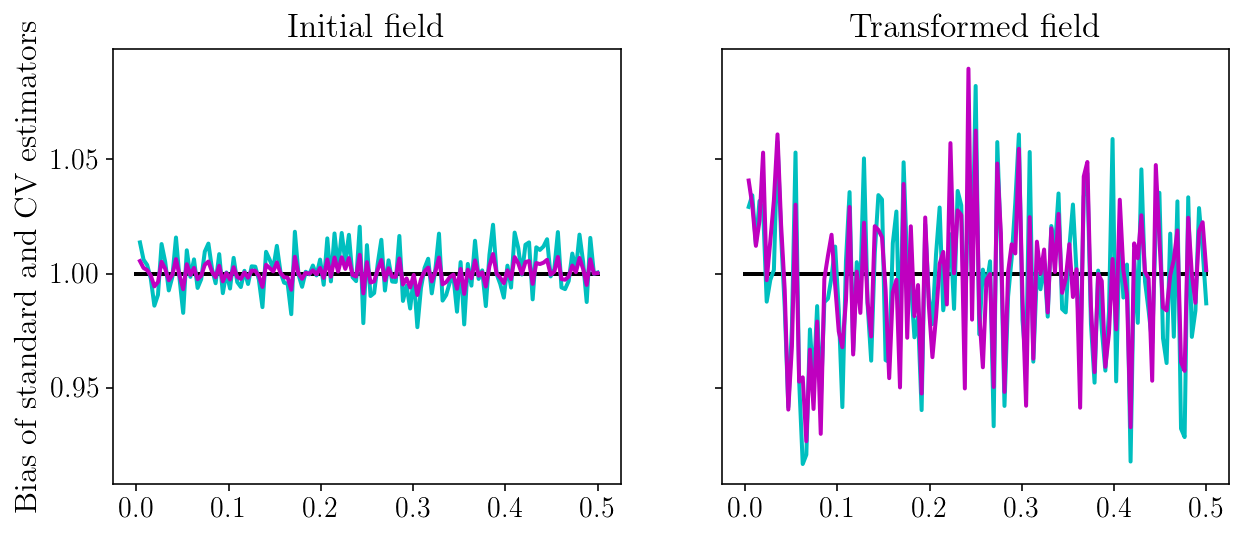

In [439]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
axs[0].plot(ks, powerspectrum*0+1)
axs[1].plot(ks, powerspectrum*0+1)
axs[0].plot(ks[1:], powerspectra_i_withbeta[:, :, 0, :].mean(axis=(0, 1))[1:]/powerspectrum[1:])
axs[0].plot(ks[1:], differences_i.mean(axis=(0, 1))[1:]/powerspectrum[1:])
axs[1].plot(ks[1:], differences.mean(axis=(0, 1))[1:]/powerspectrum_ref_mean[0, 1:])
axs[1].plot(ks[1:], powerspectra_withbeta[:, :, 0, :].mean(axis=(0, 1))[1:]/powerspectrum_ref_mean[0, 1:])
axs[0].set_title('Initial field')
axs[1].set_title('Transformed field')
axs[0].set_ylabel('Bias of standard and CV estimators')

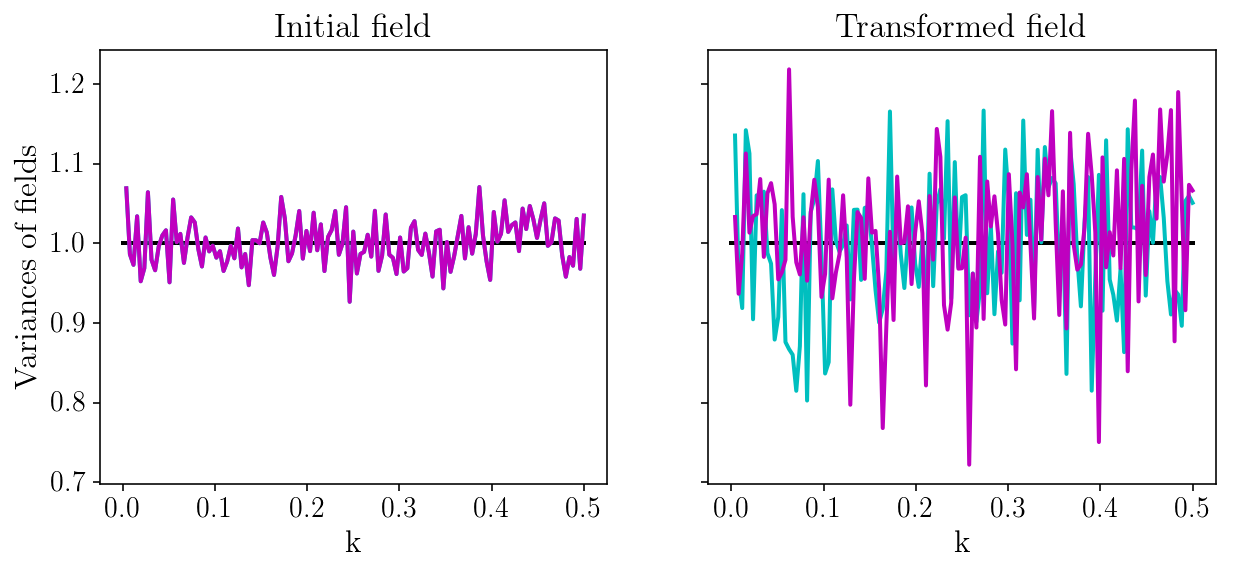

In [440]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
axs[0].plot(ks, powerspectrum*0+1)
axs[1].plot(ks, powerspectrum*0+1)
mod = powerspectrum[1:]**2 #/  n_realizations * n_repeat
axs[0].plot(ks[1:], powerspectra_i_withbeta[:, :, 0, :].var(axis=(0, 1))[1:] / mod)
mod = powerspectrum_aux[1:]**2 #/ n_repeat
axs[0].plot(ks[1:], powerspectra_i_withbeta[:, :, 1, :].var(axis=(0, 1))[1:] / mod)
#axs[0].plot(ks[1:], differences_i.mean(axis=1).var(axis=0)[1:] / mod)
mod = powerspectrum_ref_var[0, 1:] #/ n_realizations * n_repeat
axs[1].plot(ks[1:], powerspectra_withbeta[:, :, 0, :].var(axis=(0, 1))[1:] / mod)
mod = powerspectrum_ref_var[1, 1:] #/ n_realizations * n_repeat
axs[1].plot(ks[1:], powerspectra_withbeta[:, :, 1, :].var(axis=(0, 1))[1:] / mod)
#axs[1].plot(ks[1:], differences.mean(axis=1).var(axis=0)[1:] / mod)
#axs[0].set_yscale('log')
axs[0].set_title('Initial field')
axs[1].set_title('Transformed field')
axs[0].set_ylabel('Variances of fields')
axs[0].set_xlabel('k')
axs[1].set_xlabel('k')

Let's show that the variance of the new estimator is way smaller!

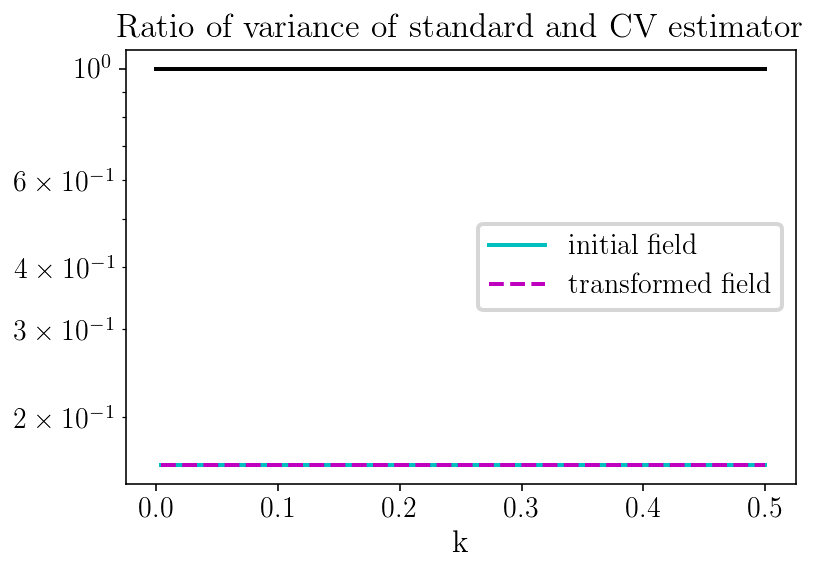

In [441]:
plt.plot(ks, powerspectrum*0+1)
meas1 = np.var(differences_i.mean(axis=1), axis=0)[1:]
meas2 = np.var(powerspectra_i_withbeta[:, :, 0, :].mean(axis=1), axis=0)[1:]
plt.plot(ks[1:], meas1 / meas2, label='initial field')
meas1 = np.var(differences.mean(axis=1), axis=0)[1:]
meas2 = np.var(powerspectra_withbeta[:, :, 0, :].mean(axis=1), axis=0)[1:]
plt.plot(ks[1:], meas1 / meas2, label='transformed field', ls='--')
plt.yscale('log')
plt.legend()
plt.title('Ratio of variance of standard and CV estimator')
plt.xlabel('k')

Let's check that our model for the variance of the sample mean estimator with the control variates works:

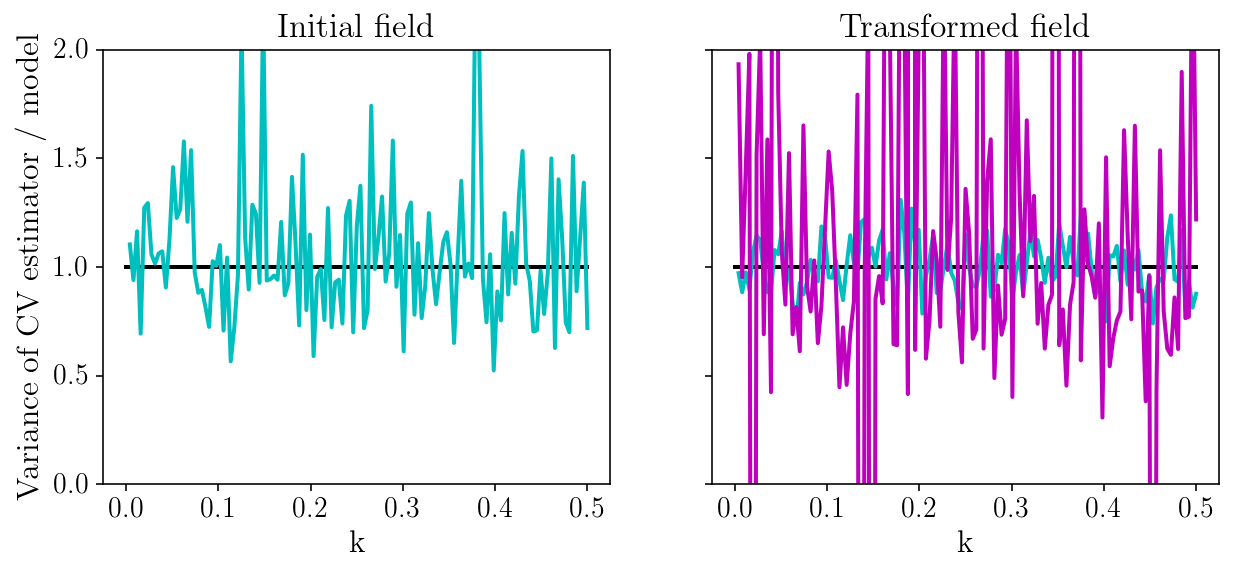

In [427]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
axs[0].plot(ks, powerspectrum*0+1)
axs[1].plot(ks, powerspectrum*0+1)
mod = (powerspectrum**2 + alphas**2 * powerspectrum_aux**2 + 2*alphas*cross_powerspectrum_i) / n_realizations
axs[0].plot(ks[1:], np.var(differences_i.mean(axis=1), axis=0)[1:]/mod[1:])

mod = (powerspectrum_ref_var[0, :] + alphas**2 * powerspectrum_ref_var[1, :] + 2*alphas*cross_powerspectrum) / n_realizations
mod2 = cross_powerspectrum_diff / n_realizations
axs[1].plot(ks[1:], np.var(differences.mean(axis=1), axis=0)[1:]/mod2[1:])
axs[1].plot(ks[1:], np.var(differences.mean(axis=1), axis=0)[1:]/mod[1:]) # using approximation!
#axs[1].plot(ks[1:], np.var(differences.mean(axis=1), axis=0)[1:])
axs[0].set_ylim([0, 2])
axs[0].set_title('Initial field')
axs[1].set_title('Transformed field')
axs[0].set_ylabel('Variance of CV estimator / model')
axs[0].set_xlabel('k')
axs[1].set_xlabel('k')

We can also compute the optimal alphas that work for the new power spectrum estimator. Hopefully I should have manually picked something that is close to those values, so we don't really have to re-run the experiments above.

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


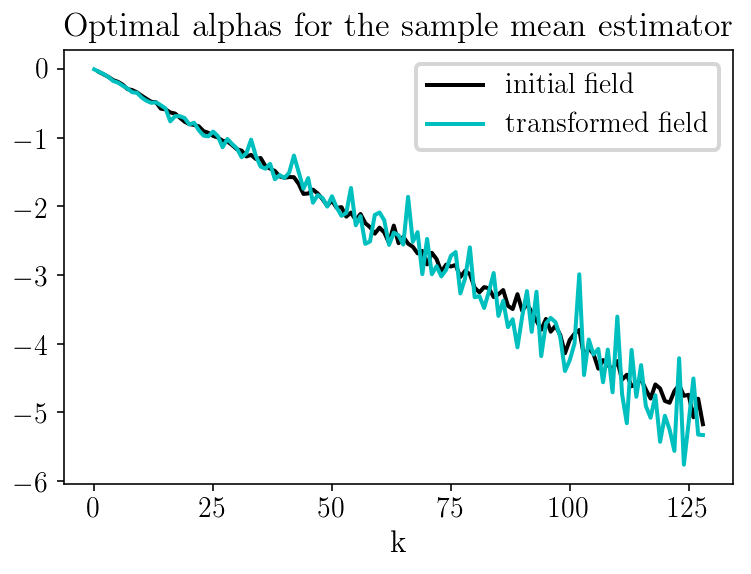

In [442]:
alphas1 = - cross_powerspectrum_i / (powerspectrum_aux[:]**2)
plt.plot(alphas1, label='initial field')
alphas2 = - cross_powerspectrum / powerspectrum_ref_var[1, :]
plt.plot(alphas2, label='transformed field')
plt.legend()
plt.title('Optimal alphas for the sample mean estimator')
plt.xlabel('k')

We now look at the covariance of the difference Pk fields and check that our theoretical models work.

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide


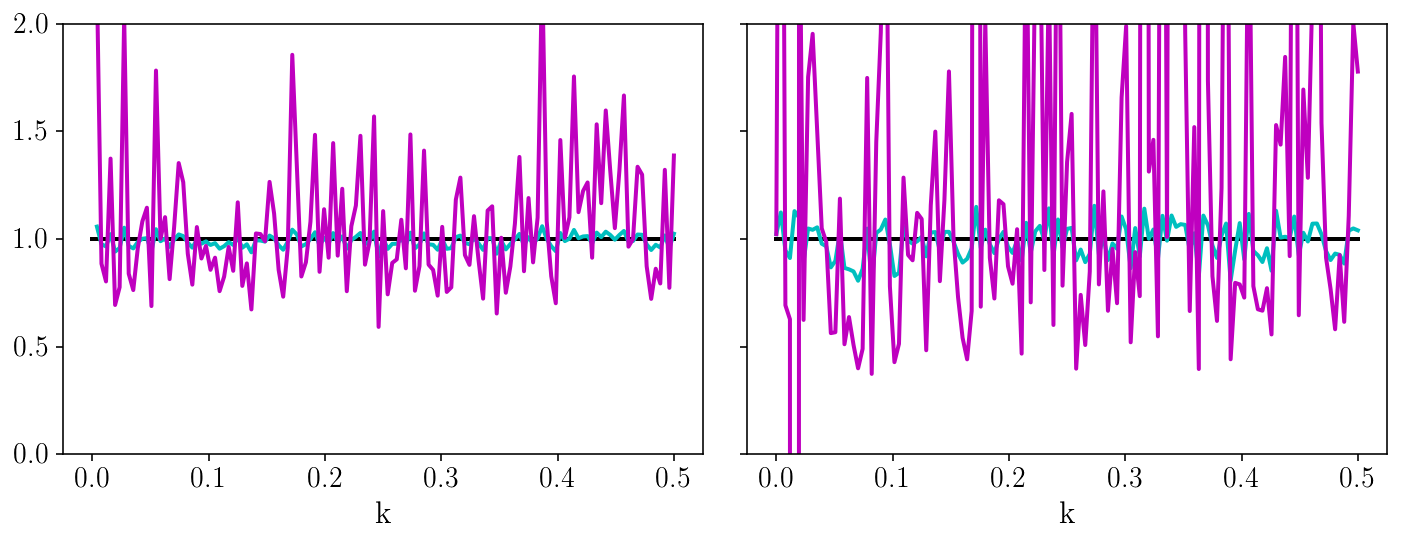

In [443]:
mod_i_1 = powerspectrum**2. 
cov_i_1 = powerspectra_i_withbeta[:, :, 0, :].var(axis=1).mean(axis=0)

mod_i_2 = powerspectrum**2 + alphas**2 * powerspectrum_aux**2 + 2*alphas*cross_powerspectrum_i 
cov_i_2 = differences_i[:, :, :].var(axis=1).mean(axis=0)

mod_1 = powerspectrum_ref_var[0, :]
cov_1 = powerspectra_withbeta[:, :, 0, :].var(axis=1).mean(axis=0)

mod_2 = powerspectrum_ref_var[0, :] + alphas**2 * powerspectrum_ref_var[1, :] + 2*alphas*cross_powerspectrum
cov_2 = differences[:, :, :].var(axis=1).mean(axis=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
axs[0].plot(ks, powerspectrum*0+1)
axs[0].plot(ks, cov_i_1 / mod_i_1)
axs[0].plot(ks, cov_i_2 / mod_i_2)
axs[1].plot(ks, powerspectrum*0+1)
axs[1].plot(ks, cov_1 / mod_1)
axs[1].plot(ks, cov_2 / mod_2)
axs[1].set_ylim([0, 2])
axs[0].set_xlabel('k')
axs[1].set_xlabel('k')
fig.tight_layout()

Finally, we measure the variance of the sample variance measured in the standard and CV estimator. And we see that the new estimator is significantly better. Even if we haven't optimized alpha. Indeed, the previous alphas are only optimal for the power spectrum estimator. For the variance we should solve another system of equations to find the optimal alphas. But luckily we see that the previous alphas already lead to a huge improvement!

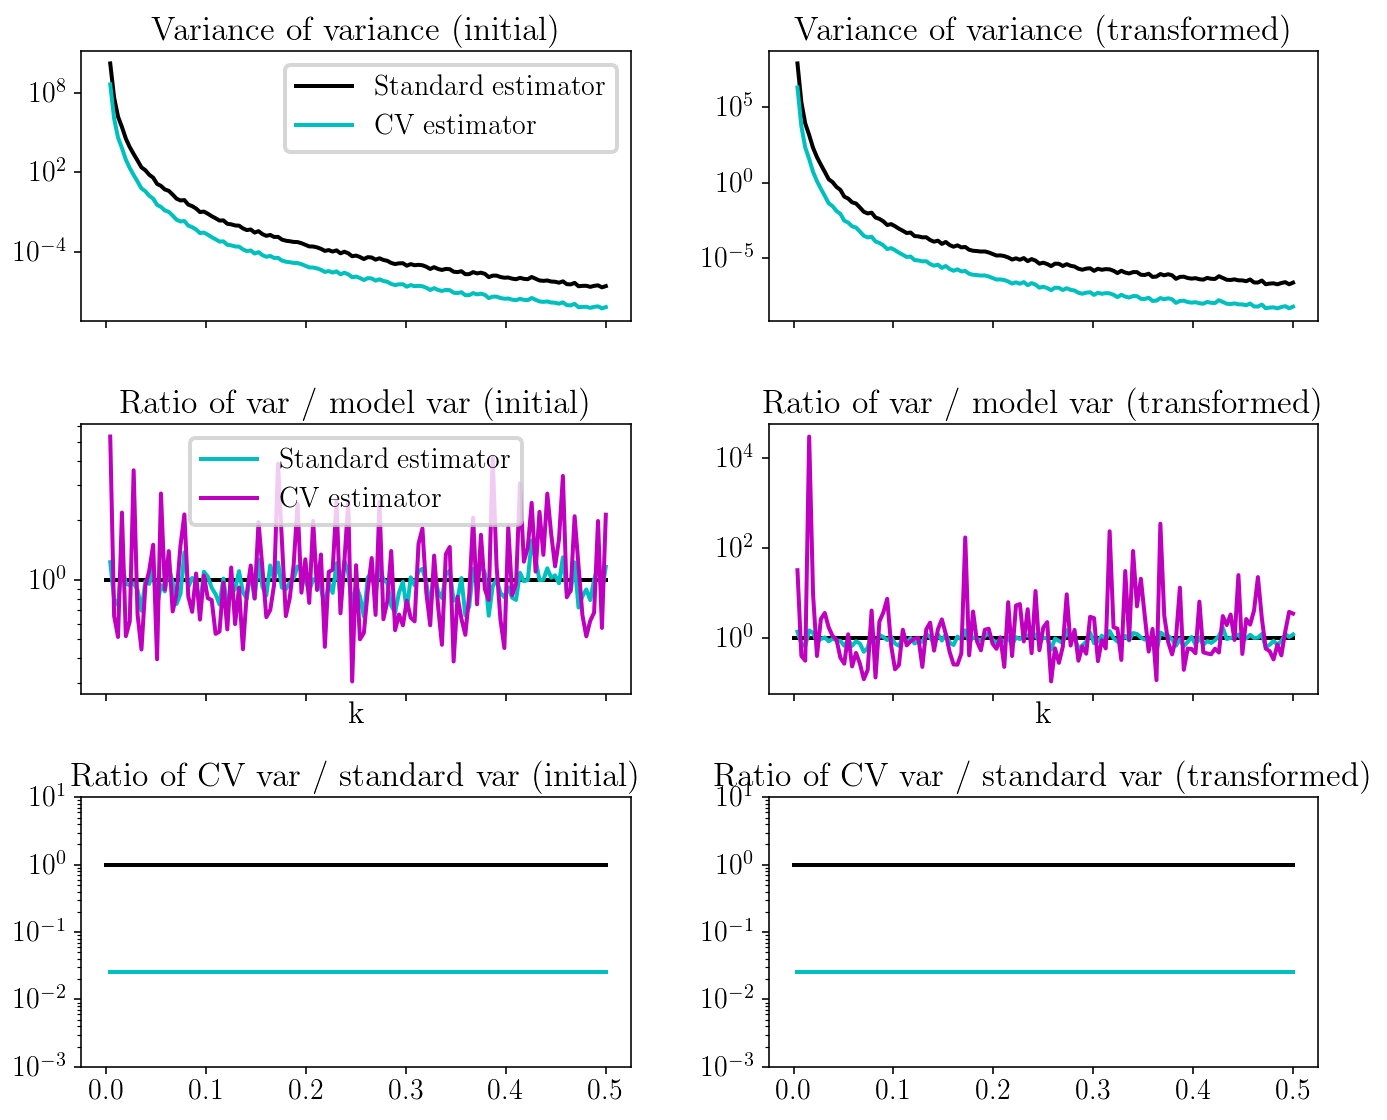

In [444]:
F = powerspectrum**2. 
mod_i_1 = 2*(2*F)**2. / (n_realizations - 1)
cov_i_1 = powerspectra_i_withbeta[:, :, 0, :].var(axis=1).var(axis=0)

F = powerspectrum**2 + alphas**2 * powerspectrum_aux**2 + 2*alphas*cross_powerspectrum_i
mod_i_2 = 2*(2*F)**2. / (n_realizations - 1) 
cov_i_2 = differences_i[:, :, :].var(axis=1).var(axis=0)

F = powerspectrum_ref_var[0, :]
mod_1 = 2*(2*F)**2. / (n_realizations - 1) 
cov_1 = powerspectra_withbeta[:, :, 0, :].var(axis=1).var(axis=0)

F = powerspectrum_ref_var[0, :] + alphas**2 * powerspectrum_ref_var[1, :] + 2*alphas*cross_powerspectrum
mod_2 = 2*(2*F)**2. / (n_realizations - 1) 
cov_2 = differences[:, :, :].var(axis=1).var(axis=0)

fig, axs = plt.subplots(3, 2, figsize=(10, 8), sharex=True, sharey=False)
axs[0, 0].plot(ks[1:], cov_i_1[1:], label='Standard estimator')
axs[0, 0].plot(ks[1:], cov_i_2[1:], label='CV estimator')
axs[0, 0].legend()
axs[0, 1].plot(ks[1:], cov_1[1:], label='Standard estimator')
axs[0, 1].plot(ks[1:], cov_2[1:], label='CV estimator')
axs[1, 0].plot(ks, powerspectrum*0+1)
axs[1, 1].plot(ks, powerspectrum*0+1)
axs[1, 0].plot(ks[1:], cov_i_1[1:] / mod_i_1[1:], label='Standard estimator')
axs[1, 0].plot(ks[1:], cov_i_2[1:] / mod_i_2[1:], label='CV estimator')
axs[1, 0].legend()
axs[1, 1].plot(ks[1:], cov_1[1:] / mod_1[1:])
axs[1, 1].plot(ks[1:], cov_2[1:] / mod_2[1:])
axs[2, 0].plot(ks, powerspectrum*0+1)
axs[2, 1].plot(ks, powerspectrum*0+1)
axs[2, 0].plot(ks[1:], cov_i_2[1:] / cov_i_1[1:])
axs[2, 1].plot(ks[1:], cov_2[1:] / cov_1[1:])
axs[0, 0].set_title('Variance of variance (initial)')
axs[0, 1].set_title('Variance of variance (transformed)')
axs[1, 0].set_title('Ratio of var / model var (initial)')
axs[1, 1].set_title('Ratio of var / model var (transformed)')
axs[2, 0].set_title('Ratio of CV var / standard var (initial)')
axs[2, 1].set_title('Ratio of CV var / standard var (transformed)')
axs[0, 0].set_yscale('log')
axs[0, 1].set_yscale('log')
axs[1, 0].set_yscale('log')
axs[1, 1].set_yscale('log')
axs[2, 0].set_yscale('log')
axs[2, 1].set_yscale('log')
axs[2, 0].set_ylim([1e-3, 1e1])
axs[2, 1].set_ylim([1e-3, 1e1])
axs[1, 0].set_xlabel('k')
axs[1, 1].set_xlabel('k')
fig.tight_layout()